In [3]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import re

In [93]:
# Trial,S1_A_val,S1_A_std,S1_B_val,S2_A_val,S2_A_std,S2_B_val

def generate_trials_csv(
    path: str,
    v_min=-5.0, v_max=5.0,
    num_conditions=150,
    s2_std_max=2.0,  std_step=0.1,
    trials_per_condition=100,
):
    values = np.linspace(v_min, v_max, num_conditions)
    # s2_stds = np.linspace(.15, .30, 3)
    s2_stds = [0.25]
    print

    S1_A_std = 8
    S2_A_std = 0


    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Trial","S1_A_val","S1_A_std", "S1_B_val","S2_A_val","S2_A_std","S2_B_val"])

        trial_id = 1
        for value in values:
            for std2 in s2_stds:
                for _ in range(trials_per_condition):
                    writer.writerow([
                        trial_id,
                         value, 8, value, # s1:  A value,  A std, B value
                        0, 0.18, 0,    # s2  A value,  A std, B value
                           
                    ])
                    trial_id += 1
    
    print(f"values saved in: {path}")

In [94]:
generate_trials_csv(path="lvl_3_prior_reverse.csv")

values saved in: lvl_3_prior_reverse.csv


In [ ]:
def plot_psychometric_vs_std(csv_path):
    df = pd.read_csv(csv_path)

    # Convert numeric columns
    df["S2_val"] = df["S2_val"].astype(float)
    df["S2_std"] = df["S2_std"].astype(float)

    # Aggregate probability per condition
    grouped = (
        df.groupby(["S2_val", "S2_std"])["Decision (S1>S2)"]
        .agg(["mean", "count"])
        .reset_index()
    )

    plt.figure(figsize=(8, 6))

    # Loop over S2_val instead of std
    for val in sorted(grouped["S2_val"].unique()):
        subset = grouped[grouped["S2_val"] == val].sort_values("S2_std")

        # ---- Find std50 (closest to 0.5) ----
        idx = np.abs(subset["mean"] - 0.5).idxmin()
        threshold_std = subset.loc[idx, "S2_std"]

        # ---- Estimate slope at std50 ----
        i = subset.index.get_loc(idx)
        window = subset.iloc[max(i-1, 0): i+2]

        # Fit a line: mean = a*S2_std + b
        coef = np.polyfit(window["S2_std"], window["mean"], 1)
        slope = coef[0]

        # ---- Convert slope → variance estimate ----
        if slope != 0:
            sigma = 1 / (np.sqrt(2*np.pi) * abs(slope))
            variance = sigma**2
        else:
            variance = np.nan

        # ---- Plot curve ----
        plt.plot(
            subset["S2_std"],
            subset["mean"],
            marker="o",
            label=f"S2_val={val} (std50={threshold_std:.2f}, Var≈{variance:.3f})"
        )

    plt.legend(title="S2_val", fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.xlabel("Stimulus noise (S2_std)")
    plt.ylabel("P(response = 1)")
    plt.title("Psychometric Function vs stimulus noise")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

In [90]:
def plot_psychometric_value(csv_path):
    df = pd.read_csv(csv_path)

    # Convert columns to numeric
    df["S1_A_val"] = df["S1_A_val"].astype(float)
    df["S2_A_val"] = df["S2_A_val"].astype(float)
    df["S2_A_std"] = df["S2_A_std"].astype(float)

    # ---------------------------------------------------
    # Determine which stimulus value is actually varying
    # ---------------------------------------------------
    if df["S1_A_val"].nunique() > 1:
        x_col = "S1_A_val"
    elif df["S2_A_val"].nunique() > 1:
        x_col = "S2_A_val"
    else:
        raise ValueError("Neither S1_A_val nor S2_A_val varies in this dataset.")

    # Compute probability per (x_col, S2_A_std)
    grouped = (
        df.groupby([x_col, "S2_A_std"])["Decision (S1>S2)"]
        .agg(["mean", "count"])
        .reset_index()
    )

    plt.figure(figsize=(8, 6))
    legend_entries = []

    # Loop over S2 noise levels
    for std in sorted(grouped["S2_A_std"].unique()):
        subset = grouped[grouped["S2_A_std"] == std].sort_values(x_col)

        x = subset[x_col].values
        y = subset["mean"].values

        plt.plot(x, y, marker="o")

        # -------- Compute PSE (y = 0.5) --------
        pse = None
        for i in range(len(y) - 1):
            if (y[i] <= 0.5 <= y[i+1]) or (y[i] >= 0.5 >= y[i+1]):
                x1, x2 = x[i], x[i+1]
                y1, y2 = y[i], y[i+1]
                t = (0.5 - y1) / (y2 - y1)
                pse = x1 + t * (x2 - x1)
                break

        if pse is not None:
            legend_entries.append(f"S2_std={std} | PSE≈{pse:.2f}")
        else:
            legend_entries.append(f"S2_std={std} | no PSE")

    plt.legend(legend_entries, title="Psychometric Curves by S2_A_std", fontsize=8)
    plt.xlabel(f"Stimulus value ({x_col})")
    plt.ylabel("P(response = S1 > S2)")
    plt.title("Psychometric Function (Grouped by S2_A_std)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

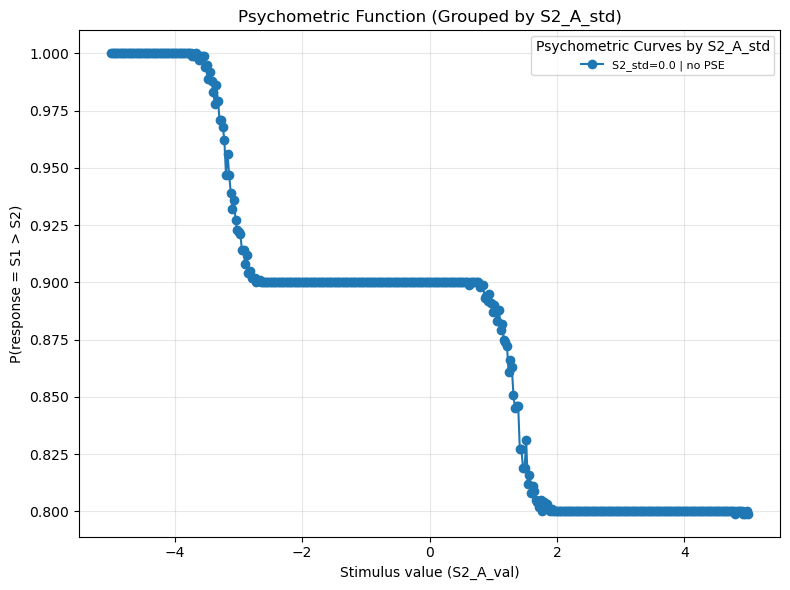

In [97]:
plot_psychometric_value("lvl_3_michael_results.csv")

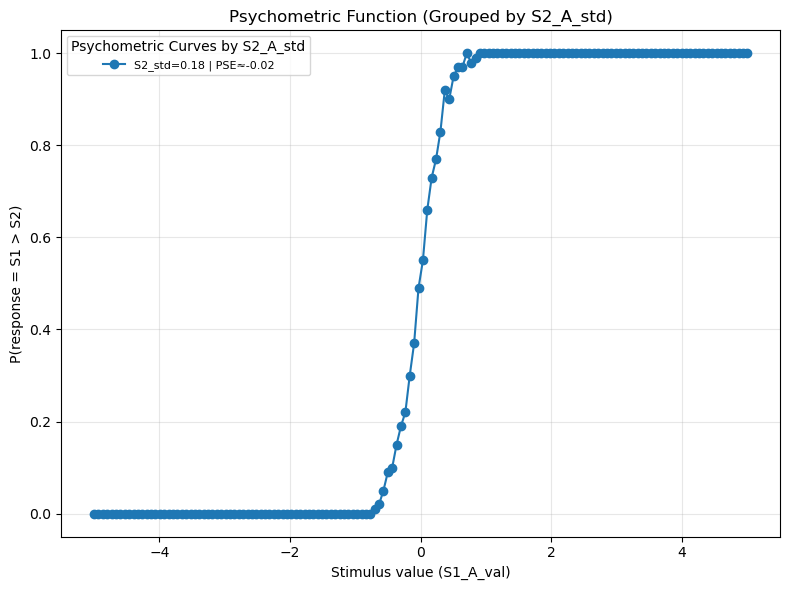

In [98]:
plot_psychometric_value("lvl_3_prior_reverse_results.csv")

In [ ]:
def extract_prior_means(csv_path):
    """
    For a single CSV file:
      - compute mean response per (S2_val, S2_std)
      - find x50 for each S2_std
      - return a DataFrame with columns:
            ["file_id", "S2_std", "x50"]
    """

    df = pd.read_csv(csv_path)

    # Parse training period from filename (lvl_5_results_500.csv → 500)
    m = re.search(r"(\d+)\.csv$", csv_path)
    file_id = int(m.group(1)) if m else None

    # Ensure numeric
    df["S2_val"] = df["S2_val"].astype(float)
    df["S2_std"] = df["S2_std"].astype(float)

    # Probability per condition
    grouped = (
        df.groupby(["S2_val", "S2_std"])["Decision (S1>S2)"]
        .mean()
        .reset_index()
    )

    results = []

    for std in sorted(grouped["S2_std"].unique()):
        subset = grouped[grouped["S2_std"] == std].sort_values("S2_val")

        # Find x50 = S2_val where mean is closest to 0.5
        idx = np.abs(subset["Decision (S1>S2)"] - 0.5).idxmin()
        x50 = subset.loc[idx, "S2_val"]

        results.append({
            "file_id": file_id,
            "S2_std": std,
            "x50": x50
        })


    return pd.DataFrame(results)

In [49]:
def extract_across_files(file_paths):
    all_results = []

    for path in file_paths:
        df_res = extract_prior_means(path)
        all_results.append(df_res)

    return pd.concat(all_results, ignore_index=True)

In [155]:

def plot_prior_means(df_results):
    """
    df_results must have:
        file_id | S2_std | x50
    (output of extract_across_files)
    """

    plt.figure(figsize=(8, 5))


    for std in sorted(df_results["S2_std"].unique()):
    

        subset = df_results[df_results["S2_std"] == std].sort_values("file_id")

        plt.plot( subset["file_id"], subset["x50"], marker=".", label=f"S2_std = {std}" )

    plt.xlabel("training trial")
    plt.ylabel("Prior mean estimate")
    plt.title("Inferred Prior Mean across Training")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Noise level (S2_std)")
    plt.tight_layout()
    plt.show()

In [ ]:
paths = sorted(
    glob.glob("/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_4/lvl_4_results_*.csv"),
    key=lambda p: int(re.search(r"(\d+)\.csv$", p).group(1))
    )
print(paths)

df_all = extract_across_files(paths)
print(df_all)


['/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_0.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_10.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_20.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_50.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_100.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_200.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_300.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_400.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_500.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_600.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_800.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_1000.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_1001.csv']
     file_id  S2_std   x50
0          0     1.0  3.87
1          0     2.0  3.8

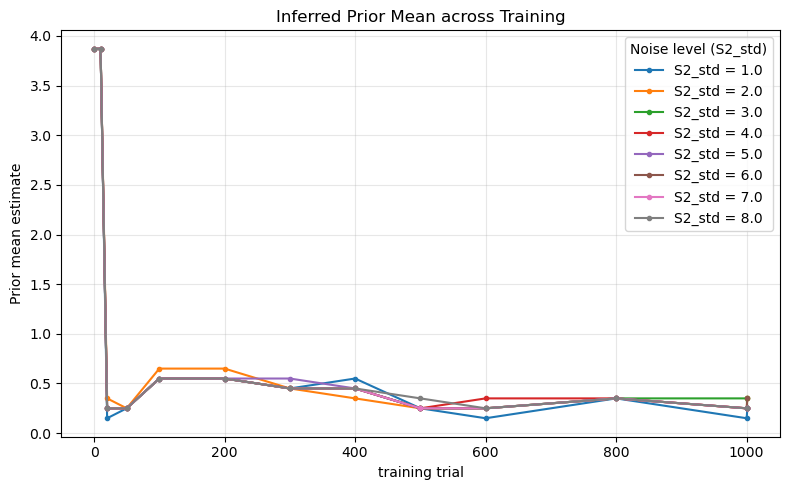

In [161]:
plot_prior_means(df_all)

In [108]:
def plot_mu_prior(csv_path):
    df = pd.read_csv(csv_path)

    # ensure numeric, remove commas/spaces if needed
    df["mu_prior"] = df["mu_prior"].astype(float)
    df["Trial"] = df["Trial"].astype(int)

    plt.figure(figsize=(8, 5))
    plt.plot(df["Trial"], df["mu_prior"], linewidth=1)

    plt.xlabel("Trial")
    plt.ylabel("mu_prior")
    plt.title("Evolution of Mu_Prior Across Trials")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

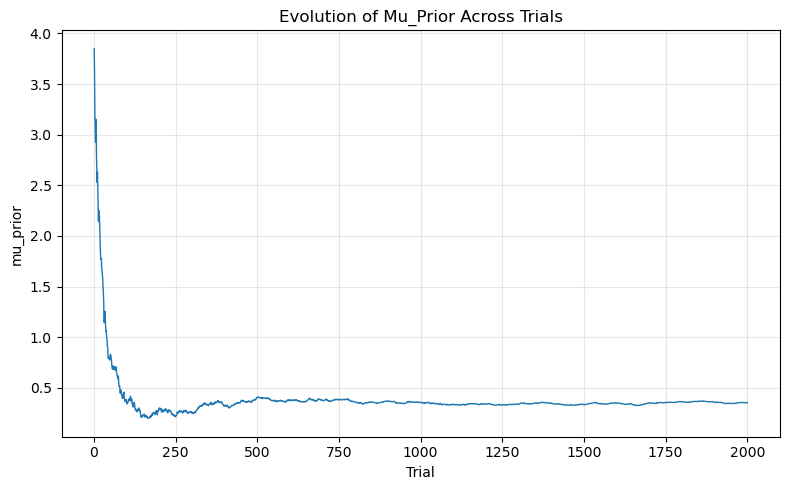

In [113]:
plot_mu_prior("/Users/arielventura/cog-sup/cogsup-prog/bayes/training_history.csv")